In [1]:
import plotly.express as px


In [2]:
# Insert the directory
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [3]:
from review_df import ReviewDF
df = ReviewDF.get_df()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [4]:
import sklearn
from sklearn.model_selection import train_test_split

# split set
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size= .15, random_state= 111, stratify= None )
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size= .25, random_state= 111, stratify= None )

In [5]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 4.4 MB 29.1 MB/s 
     |████████████████████████████████| 1.2 MB 51.5 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 596 kB 54.0 MB/s 
     |████████████████████████████████| 6.6 MB 51.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b6354a526255dfb6387de9d667b66d4105051dfea708b8865d23dd7432370585
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model.max_seq_length = 110
model._first_module().max_seq_length = 110

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [7]:
embed_train = model.encode(x_train.tolist(), convert_to_numpy=True, show_progress_bar=True)

Batches:   0%|          | 0/5906 [00:00<?, ?it/s]

In [ ]:
first_sen = x_train.tolist()[0]
first_emb = model[0]
first_sen
first_emb
# model.encode("dummy text").shape

Transformer({'max_seq_length': 110, 'do_lower_case': False}) with Transformer model: BertModel 

In [8]:
embed_val = model.encode(x_val.tolist(), convert_to_numpy=True, show_progress_bar=True)

Batches:   0%|          | 0/1969 [00:00<?, ?it/s]

In [9]:
embed_test = model.encode(x_test.tolist(), convert_to_numpy=True, show_progress_bar=True)

Batches:   0%|          | 0/1390 [00:00<?, ?it/s]

In [ ]:
model.max_seq_length

110

In [ ]:
y_train.dtype

dtype('int64')

In [10]:
import tensorflow as tf

from keras import Sequential, regularizers 

from keras.layers import Embedding, LSTM, Dense
from keras import losses

embedding_dim = 384
sequence_length = 110
cells = 100
batch_size= 64
epochs = 10
unique_words = 15000

from keras.layers import Dense
from keras.layers import Flatten, InputLayer

bertLayerModel = tf.keras.Sequential(
   [ 
    InputLayer(input_shape=(384,)),
  Dense(32,activation='relu'),
  Dense(64,activation='relu'),
  # Dense(32,activation='relu'),
  Dense(2,activation='sigmoid')]
)

In [11]:
from tensorflow import keras

# bertLayerModel.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(1e-3),metrics=metrics)

bertLayerModel.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(1e-3),metrics=['accuracy'])

In [12]:
bertLayerModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                12320     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 14,562
Trainable params: 14,562
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embed_train.shape

(188991, 384)

(72572544, 1)

In [13]:
import time

from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
start = time.time()
berthist = bertLayerModel.fit(embed_train,y_train,validation_data= (embed_val, y_val),
                    epochs= epochs,batch_size= batch_size, verbose=1, callbacks=[earlyStopping, mcp_save])
print(time.time()-start)

Epoch 1/10
2953/2953 [==============================] - 12s 4ms/step - loss: 0.2514 - accuracy: 0.8956 - val_loss: 0.2339 - val_accuracy: 0.9025
Epoch 2/10
2953/2953 [==============================] - 10s 3ms/step - loss: 0.2259 - accuracy: 0.9062 - val_loss: 0.2293 - val_accuracy: 0.9038
Epoch 3/10
2953/2953 [==============================] - 9s 3ms/step - loss: 0.2174 - accuracy: 0.9093 - val_loss: 0.2252 - val_accuracy: 0.9050
Epoch 4/10
2953/2953 [==============================] - 11s 4ms/step - loss: 0.2118 - accuracy: 0.9119 - val_loss: 0.2228 - val_accuracy: 0.9066
Epoch 5/10
2953/2953 [==============================] - 10s 4ms/step - loss: 0.2075 - accuracy: 0.9141 - val_loss: 0.2226 - val_accuracy: 0.9061
Epoch 6/10
2953/2953 [==============================] - 9s 3ms/step - loss: 0.2037 - accuracy: 0.9158 - val_loss: 0.2224 - val_accuracy: 0.9069
Epoch 7/10
2953/2953 [==============================] - 9s 3ms/step - loss: 0.2007 - accuracy: 0.9168 - val_loss: 0.2227 - val_accur

In [ ]:
print(time.time()-start)

115.28583550453186


In [14]:
import torch
file_name = "/content/drive/MyDrive/Colab Notebooks/sbert_model"

In [15]:
torch.save(model, file_name)

In [16]:
saved_model = torch.load(file_name)

In [17]:
import numpy as np
bertLayerModel_pred = bertLayerModel.predict(embed_test)
bertLayerModel_y = np.argmax(bertLayerModel_pred, axis = 1)
bertLayerModel_y

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
bertLayerModel_y.shape

(44469,)

In [ ]:
y_test.shape

(44469,)

In [18]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score


print('Accuracy:', accuracy_score(bertLayerModel_y, y_test))
print('F1 score:', f1_score(y_test, bertLayerModel_y))
print('Recall:', recall_score(y_test, bertLayerModel_y))
print('Precision:', precision_score(y_test, bertLayerModel_y))

print(classification_report(y_test, bertLayerModel_y))

Accuracy: 0.906294272414491
F1 score: 0.9465158963432635
Recall: 0.9622380542289726
Precision: 0.9312992523742171
              precision    recall  f1-score   support

           0       0.70      0.56      0.62      6150
           1       0.93      0.96      0.95     38319

    accuracy                           0.91     44469
   macro avg       0.82      0.76      0.78     44469
weighted avg       0.90      0.91      0.90     44469



In [ ]:
weighted_results = bertLayerModel.evaluate(embed_test, y_test,
                                           batch_size=64, verbose=0)
for name, value in zip(bertLayerModel.metrics_names, weighted_results):
  print(name, ': ', value)
print()

loss :  0.2287319153547287
accuracy :  0.9066765904426575



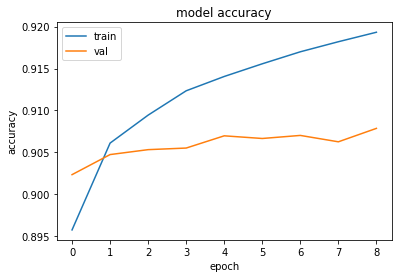

In [ ]:
from matplotlib import pyplot as plt

plt.plot(berthist.history['accuracy'])
plt.plot(berthist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

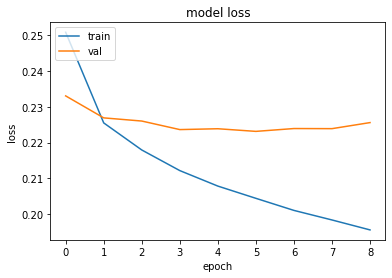

In [ ]:
from matplotlib import pyplot as plt

plt.plot(berthist.history['loss'])
plt.plot(berthist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics

precision, recall, thresholds = precision_recall_curve(bertLayerModel_y, y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, bertLayerModel_y, pos_label=1)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()